# Exemplo de uso Tensorboard com MNIST

O Tensorboard é uma ferramenta integrada ao tensorflow que permite a visualização de estatísticas de uma rede neural como parâmetros de treinamento (perda, acurácia e pesos), imagens e o grafo construído. Ele é útil para ajudar a entender o fluxo dos tensores no grafo e também corrigir e otimizar o modelo.

O Tensorboard funciona lendo *event files* escritos por uma aplicação Tensorflow que escreve as *summary data*. 

Para executar o Tensoboard deve-se utilizar o comando: tensorboard --logdir=[dir] onde [dir] é o diretório onde estão localizados os *event files*. 

Para escrever um *event file* é preciso criar uma instância *FileWriter*, e para isso basta chamar seu construtor *tf.summary.FileWriter([dir], [graph])*, onde [dir] é o diretório dos *event files* e [graph] é o grafo construído.

Para gerar os dados que serão observados podemos utilizar a função tf.summary.scalar(name, data)onde scalar pode ser histogram, image, audio e text, dependendo do tipo do dado a ser visualizado.

Por fim usamos writer.add_summary(summary, step) para escrever os dados no event file, onde writer é uma instância de FileWriter.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

import datetime, os
import pathlib, shutil
import random
#import tensorboard

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, models, utils

%load_ext tensorboard

In [2]:
IMG_SIZE = 50
BATCH_SIZE = 2000
EPOCHS = 10

DATADIR = "/data/dataset/mnist/trainingSet/trainingSet"
TESTDIR = "/data/dataset/mnist/trainingSample/trainingSample"
CATEGORIES = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

logs_base_dir = "./logs"
shutil.rmtree(logs_base_dir, ignore_errors=True, onerror=None)
os.makedirs(logs_base_dir, exist_ok=True)

In [3]:
data_train = pathlib.Path(DATADIR)
data_test = pathlib.Path(TESTDIR)

SIZE_OF_DATASET = len(list(data_train.glob('*/*.jpg')))
SIZE_OF_TEST = len(list(data_test.glob('*/*.jpg')))

print("Number of training images: ",SIZE_OF_DATASET)
print("Number of test images: ",SIZE_OF_TEST)

Number of training images:  42000
Number of test images:  600


In [4]:
def prep_data(DATA_DIR, CATEGORIES):
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR,category)
        class_num = CATEGORIES.index(category)
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append([new_array, class_num])
        plt.figure(figsize=(1,1))
        plt.imshow(new_array, cmap='gray')
        plt.show()
    return data

In [5]:
def prep_2(data):
    random.shuffle(data)
    X = []
    y = []
    for features,label in data:
        X.append(features)
        y.append(label)
    res = np.eye(10)[y]
    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    return X, res

100%|██████████| 60/60 [00:00<00:00, 119.66it/s]


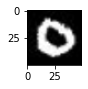

100%|██████████| 60/60 [00:00<00:00, 162.42it/s]


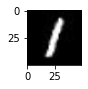

100%|██████████| 60/60 [00:00<00:00, 141.06it/s]


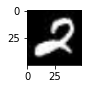

100%|██████████| 60/60 [00:00<00:00, 182.85it/s]


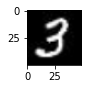

100%|██████████| 60/60 [00:00<00:00, 121.68it/s]


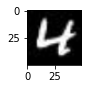

100%|██████████| 60/60 [00:00<00:00, 164.72it/s]


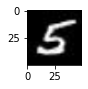

100%|██████████| 60/60 [00:00<00:00, 183.33it/s]


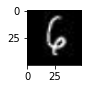

100%|██████████| 60/60 [00:00<00:00, 155.45it/s]


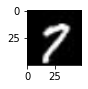

100%|██████████| 60/60 [00:00<00:00, 159.62it/s]


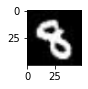

100%|██████████| 60/60 [00:00<00:00, 154.58it/s]


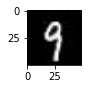

100%|██████████| 4132/4132 [00:27<00:00, 152.08it/s]


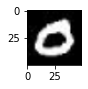

100%|██████████| 4684/4684 [00:31<00:00, 148.44it/s]


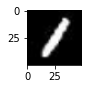

100%|██████████| 4177/4177 [00:25<00:00, 161.24it/s]


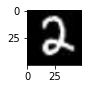

100%|██████████| 4351/4351 [00:24<00:00, 181.23it/s]


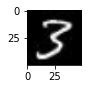

100%|██████████| 4072/4072 [00:26<00:00, 154.33it/s]


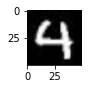

100%|██████████| 3795/3795 [00:25<00:00, 150.81it/s]


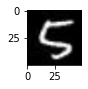

100%|██████████| 4137/4137 [00:24<00:00, 169.39it/s]


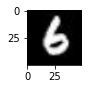

100%|██████████| 4401/4401 [00:23<00:00, 184.47it/s]


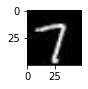

100%|██████████| 4063/4063 [00:24<00:00, 163.77it/s]


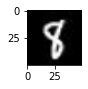

100%|██████████| 4188/4188 [00:23<00:00, 174.79it/s]


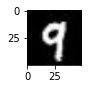

In [6]:
data = prep_data(TESTDIR, CATEGORIES)
tX, ty = prep_2(data)

data2 = prep_data(DATADIR, CATEGORIES)
X, y = prep_2(data2)

In [7]:
X=np.array(X/255.0)
y=np.array(y)

tX=np.array(tX/255.0)
ty=np.array(ty)

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (16, 16), activation='relu', input_shape=(X.shape[1:])))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add( layers.Flatten( ) )
model.add( layers.Dense(128, activation='relu') )
model.add( layers.Dense(10, activation='softmax') )

In [9]:
#opt = tf.keras.optimizers.SGD(
#    learning_rate=0.01, momentum=0.1, nesterov=False, name="SGD")

model.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(logs_base_dir, histogram_freq=1)

history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(tX, ty), callbacks=[tensorboard_callback])

Epoch 1/10
21/21 [==============================] - 25s 1s/step - loss: 1.4565 - accuracy: 0.5651 - val_loss: 0.4213 - val_accuracy: 0.8683
Epoch 2/10
21/21 [==============================] - 24s 1s/step - loss: 0.3442 - accuracy: 0.8993 - val_loss: 0.2039 - val_accuracy: 0.9300
Epoch 3/10
21/21 [==============================] - 24s 1s/step - loss: 0.1802 - accuracy: 0.9458 - val_loss: 0.1180 - val_accuracy: 0.9567
Epoch 4/10
21/21 [==============================] - 24s 1s/step - loss: 0.1199 - accuracy: 0.9634 - val_loss: 0.0800 - val_accuracy: 0.9750
Epoch 5/10
21/21 [==============================] - 25s 1s/step - loss: 0.0928 - accuracy: 0.9733 - val_loss: 0.0653 - val_accuracy: 0.9750
Epoch 6/10
21/21 [==============================] - 24s 1s/step - loss: 0.0772 - accuracy: 0.9774 - val_loss: 0.0447 - val_accuracy: 0.9900
Epoch 7/10
21/21 [==============================] - 24s 1s/step - loss: 0.0639 - accuracy: 0.9816 - val_loss: 0.0349 - val_accuracy: 0.9950
Epoch 8/10
21/21 [==

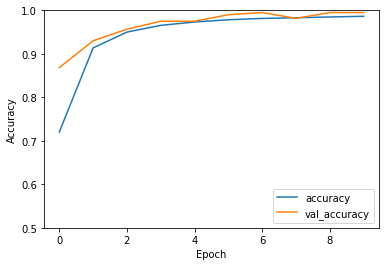

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [11]:
#%tensorboard --logdir=logs_base_dir

In [12]:
%tensorboard --logdir /home/marcial/lasid-imagens/logs --bind_all 
### --host 10.129.64.30 

Reusing TensorBoard on port 6007 (pid 7658), started 1 day, 1:23:53 ago. (Use '!kill 7658' to kill it.)

In [13]:
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir /home/marcial/lasid-imagens/logs (started 1:38:23 ago; pid 22787)
  - port 6007: logdir /home/marcial/lasid-imagens/logs (started 1 day, 1:23:53 ago; pid 7658)


In [14]:
#notebook.display(port=6006, height=1000) 